In [1]:
from collections import defaultdict
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from skimage import io
from scipy import sparse, linalg
from scipy.sparse import csgraph

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.cluster import SpectralClustering, KMeans, AffinityPropagation

In [2]:
third_node = pd.read_csv('data/results/third_node.csv')

In [3]:
third_node = third_node.drop(labels=['Unnamed: 0'], axis=1)

In [4]:
uri_to_index = np.concatenate((pd.unique(third_node.node_artist.values), pd.unique(third_node.edge_uri.values)))
uri_map = pd.DataFrame(data=np.unique(uri_to_index), columns=['uri']) # len(uri_map) 1141

In [5]:
new_list =[]
for col, series in third_node.iterrows():
    node_index = uri_map[uri_map.uri == series.node_artist].index[0]
    edge_index = uri_map[uri_map.uri == series.edge_uri].index[0]
    new_list.append([node_index,edge_index])

In [6]:
new_edges = pd.DataFrame(new_list)
edgesnp = new_edges.to_numpy(dtype = int)

In [7]:
adj_mat = {
    'undirected'          : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'undirected_weighted' : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'directed'            : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'directed_weighted'   : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
}
L = {
    'undirected'          : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'undirected_weighted' : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'directed'            : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'directed_weighted'   : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    
    'undirected_norm'          : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'undirected_weighted_norm' : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'directed_norm'            : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
    'directed_weighted_norm'   : np.zeros(shape=(np.max(edgesnp)+1,np.max(edgesnp)+1 )),
}

In [8]:
for node in edgesnp:
    adj_mat['undirected'][node[0],node[1]] = 1
    adj_mat['undirected'][node[1],node[0]] = 1
    
    adj_mat['undirected_weighted'][node[0],node[1]] +=1
    adj_mat['undirected_weighted'][node[1],node[0]] +=1
    
    adj_mat['directed'][node[1],node[0]] = 1
    adj_mat['directed_weighted'][node[1],node[0]] += 1

In [9]:
for key, val in adj_mat.items():
    L[key] = csgraph.laplacian(val)
    L[key + '_norm'] = csgraph.laplacian(val, normed=True)

In [10]:
nk = 6
nc = 2
warnings.filterwarnings("ignore")
iso = Isomap(n_neighbors=nk, n_components=nc).fit_transform(adj_mat['undirected'])
uri_map[f'iso_nn{nk}_nc{nc}_1'] = iso[:,0]
uri_map[f'iso_nn{nk}_nc{nc}_2'] = iso[:,1]

SE = SpectralEmbedding(affinity='precomputed',n_components=nc, gamma=0.1,n_neighbors =nk).fit(adj_mat['undirected'])
SE.embedding_[:,0]

uri_map[f'se_nn{nk}_nc{nc}_1'] = SE.embedding_[:,0]
uri_map[f'se_nn{nk}_nc{nc}_2'] = SE.embedding_[:,1]


KM = KMeans(n_clusters=nk,algorithm='elkan').fit(uri_map[[f'iso_nn{nk}_nc{nc}_1',f'iso_nn{nk}_nc{nc}_2']])

uri_map[f'km_nn{nk}_nc2'] = KM.labels_


warnings.filterwarnings("always")

In [11]:
nk = 9
nc = 3
warnings.filterwarnings("ignore")
iso = Isomap(n_neighbors=nk, n_components=nc).fit_transform(adj_mat['undirected'])
uri_map[f'iso_nn{nk}_nc{nc}_1'] = iso[:,0]
uri_map[f'iso_nn{nk}_nc{nc}_2'] = iso[:,1]
uri_map[f'iso_nn{nk}_nc{nc}_3'] = iso[:,2]

SE = SpectralEmbedding(affinity='precomputed',n_components=nc, gamma=0.1,n_neighbors =nk).fit(adj_mat['undirected'])
SE.embedding_[:,0]

uri_map[f'se_nn{nk}_nc{nc}_1'] = SE.embedding_[:,0]
uri_map[f'se_nn{nk}_nc{nc}_2'] = SE.embedding_[:,1]
uri_map[f'se_nn{nk}_nc{nc}_3'] = SE.embedding_[:,2]


KM = KMeans(n_clusters=nk,algorithm='elkan').fit(uri_map[[f'iso_nn{nk}_nc{nc}_1',f'iso_nn{nk}_nc{nc}_2',f'iso_nn{nk}_nc{nc}_3']])

uri_map[f'km_nn{nk}_nc{nc}'] = KM.labels_


warnings.filterwarnings("always")

In [12]:
uri_map['km_nn6_nc2'] = KM.labels_

In [13]:
uri_map.head()

,uri,iso_nn6_nc2_1,iso_nn6_nc2_2,se_nn6_nc2_1,se_nn6_nc2_2,km_nn6_nc2,iso_nn9_nc3_1,iso_nn9_nc3_2,iso_nn9_nc3_3,se_nn9_nc3_1,se_nn9_nc3_2,se_nn9_nc3_3,km_nn9_nc3
0,spotify:artist:01WjpKiWVNurV5hjIadB8C,-0.827827,2.454767,-0.009891,0.059507,1,-0.609794,1.974029,-0.166049,-0.009891,0.059507,-0.012482,1
1,spotify:artist:02NfyD6AlLA12crYzw5YcR,-2.065492,8.415246,-0.012815,0.068954,4,-2.646985,8.068464,-1.208217,-0.012815,0.068954,0.008179,4
2,spotify:artist:02da1vDJ2hWqfK7aJL6SJm,5.967168,4.189702,-0.018383,0.005573,0,4.841379,5.086020,3.594868,-0.018383,0.005573,-0.000926,0
3,spotify:artist:0539gq2LM2VDs01rp8gnGz,-2.575314,-1.662407,0.062961,-0.005974,5,-2.373169,-1.891014,0.370791,0.062961,-0.005974,-0.100760,5
4,spotify:artist:07jc1IMGtecDZzOL9cP50t,-1.721144,10.200222,-0.009354,0.060154,4,-2.772502,8.667534,-0.425490,-0.009354,0.060154,-0.004940,4


<AxesSubplot:xlabel='se_nn6_nc2_2', ylabel='se_nn6_nc2_1'>

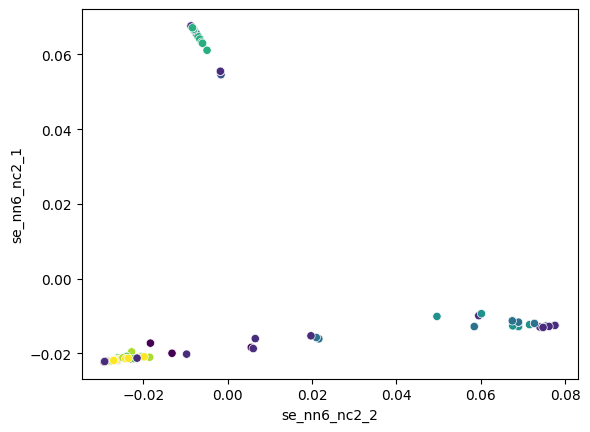

In [14]:
%matplotlib inline
sns.scatterplot(data=uri_map,y='se_nn6_nc2_1',x='se_nn6_nc2_2', c=uri_map['km_nn6_nc2'])

In [15]:
warnings.filterwarnings("ignore")
iso = Isomap(n_neighbors=30, n_components=2).fit_transform(adj_mat['undirected'])
uri_map['iso_n6_p1'] = iso[:,0]
uri_map['iso_n6_p2'] = iso[:,1]
warnings.filterwarnings("always")

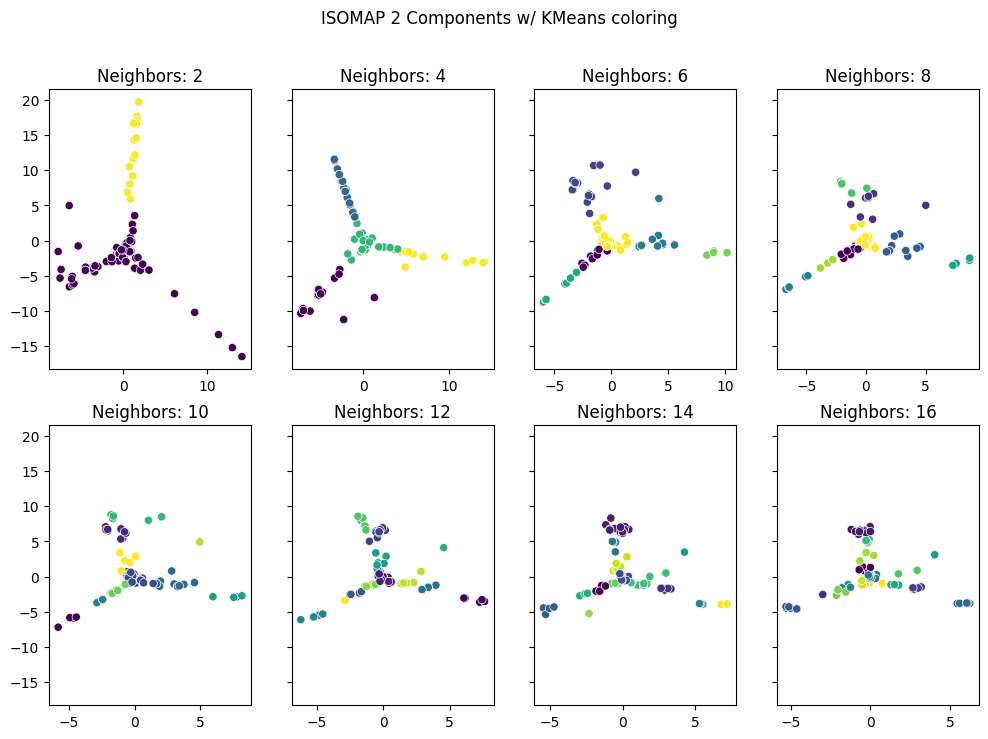

In [16]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(2,4, figsize=(12,8), sharey=True)
ii = -1
jj=0
for i, k in enumerate([2,4,6,8,10,12,14,16]):
    iso = Isomap(n_neighbors=k, n_components=2).fit_transform(adj_mat['undirected'])
    SS = pd.DataFrame()
    SS['1'] = iso[:,0]
    SS['2'] = iso[:,1]
    KM = KMeans(n_clusters=k,algorithm='elkan').fit(SS)
    if i % 4 ==0:
        ii+=1
        jj=0
    s = sns.scatterplot(ax=axes[ii,jj],data = SS, y='1',x='2', c=KM.labels_)
    s.set_title('Neighbors: ' + str(k))
    s.set_xlabel('')
    s.set_ylabel('')
    jj +=1

plt.suptitle('ISOMAP 2 Components w/ KMeans coloring')
plt.show()

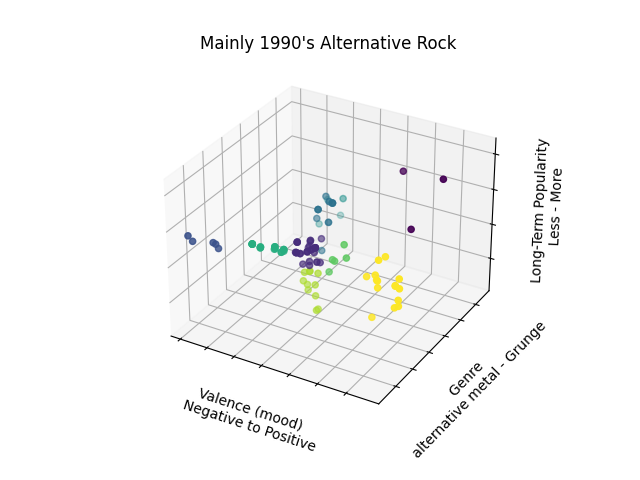

In [34]:
warnings.filterwarnings("ignore")

%matplotlib widget
# #calling it a second time may prevent some graphics errors
# %matplotlib widget  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = uri_map['iso_nn9_nc3_1']
y = uri_map['iso_nn9_nc3_2']
z = uri_map['iso_nn9_nc3_3']

ax.set_title("Mainly 1990's Alternative Rock")
ax.set_xlabel("Valence (mood) \n Negative to Positive")
ax.set_ylabel("Genre \n alternative metal - Grunge ")
ax.set_zlabel("Long-Term Popularity \n Less - More")
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_zticklabels('')
ax.scatter(x, y, z,c=uri_map['km_nn9_nc3'])

plt.show()
warnings.filterwarnings("always")

In [18]:
uri_map.to_csv('data/results/uri_map_3rd_cluster.csv')

In [20]:
LLE = LocallyLinearEmbedding(n_components=3).fit(adj_mat['undirected'])

C:\Users\ja238f\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\ipywidgets\widgets\widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
C:\Users\ja238f\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\ipywidgets\widgets\widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


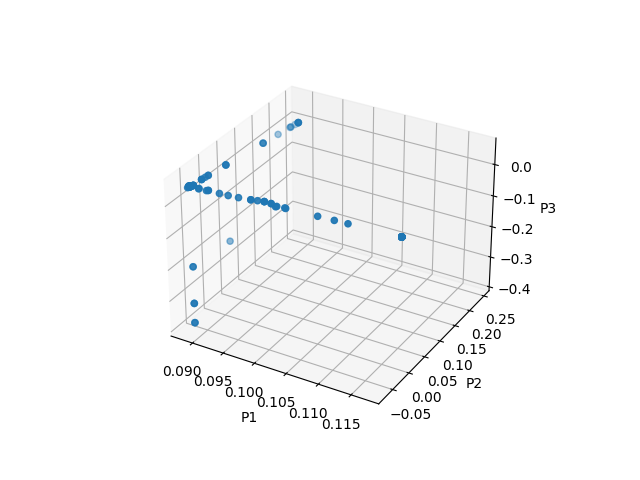

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = LLE.embedding_[:,0]
y = LLE.embedding_[:,1]
z = LLE.embedding_[:,2]

ax.set_xlabel("P1")
ax.set_ylabel("P2")
ax.set_zlabel("P3")

ax.scatter(x, y, z)

plt.show()

In [23]:
SE = SpectralEmbedding(affinity='precomputed',n_components=3, gamma=0.1,n_neighbors =4).fit(adj_mat['undirected'])
# SE.embedding_[:,0]

C:\Users\ja238f\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\ipywidgets\widgets\widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
C:\Users\ja238f\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\ipywidgets\widgets\widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


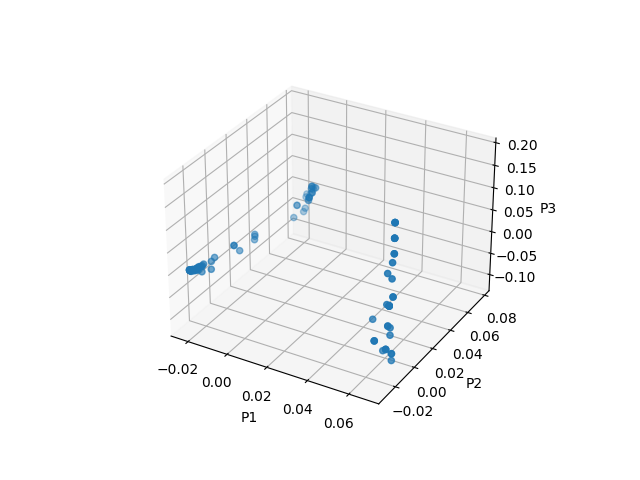

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = SE.embedding_[:,0]
y = SE.embedding_[:,1]
z = SE.embedding_[:,2]

ax.set_xlabel("P1")
ax.set_ylabel("P2")
ax.set_zlabel("P3")

ax.scatter(x, y, z)

plt.show()